In [1]:
%matplotlib inline
import numpy as np
import pdb
import matplotlib.pyplot as plt
import glob
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
import copy
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import math
np.random.seed(0)

In [2]:
def PCA(X_scale):
    num_n, num_d = X_scale.shape
    cov = np.matmul(np.transpose(X_scale), X_scale) / num_n
    value, vector = np.linalg.eig(cov)
    index = value.argsort()[::-1]
    value_sorted = value[index]
    total_var, k = sum(value_sorted), 0
    curr_sum = 0
    for i, eig in enumerate(value_sorted):
        curr_sum += eig
        if curr_sum / total_var >= 0.99:
            k = i+1
            break
    k_ind = index[:k]
    principle = vector[:,k_ind]
    return np.matmul(X_scale, principle), principle

def prepare(X, p_num):
    if p_num == 'a':
        return copy.deepcopy(X)
    elif p_num == 'b':
        return preprocessing.scale(X, with_mean=True, with_std=True)
    elif p_num == 'c':
        X_scale = preprocessing.scale(X, with_mean=True, with_std=False)
        new_feature, principle = PCA(X_scale)
        return new_feature, principle
    elif p_num == 'd':
        X_scale = preprocessing.scale(X, with_mean=True, with_std=True)
        new_feature, principle = PCA(X_scale)
        return new_feature, principle

In [3]:
###### data ######
digits = datasets.fetch_california_housing()
X = digits.data[:2000]
Y_original = digits.target[:2000]
median = np.median(Y_original)
Y = np.where(Y_original >= median, 1, 0)
kf = KFold(n_splits=10, shuffle=True)

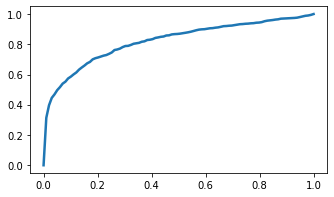

In [4]:
### part a ###
auc_all = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train = prepare(X_train, 'a')
    mlp = MLPClassifier(hidden_layer_sizes=(4,), 
                           max_iter=50, batch_size=32, verbose=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp.fit(X_train, y_train)
    X_test = prepare(X_test, 'a')
    y_pred = mlp.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    auc_all.append(auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
auc_mean = round(np.mean(auc_all),2)
auc_std = round(np.std(auc_all) / math.sqrt(10),3)
mean_tpr = np.mean(tprs, axis=0)
fig, axs = plt.subplots(1, 1, gridspec_kw={'hspace': 0.1, 'wspace': 0.2, 'bottom': 0.13, 
                                    'top': 0.9, 'right':0.995, 'left':0.17}, figsize=(5,3))
axs.plot(mean_fpr, mean_tpr, label=f'part (a) mean:{auc_mean}\n confi. interval: {auc_std}', lw=2.5)

In [5]:
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
#                                    estimator_name='part (a)')
# display.plot()

In [6]:
### part b ###
auc_all = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train = prepare(X_train, 'b')
    mlp = MLPClassifier(hidden_layer_sizes=(4,), 
                           max_iter=50, batch_size=32, verbose=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp.fit(X_train, y_train)
    X_test = prepare(X_test, 'b')
    y_pred = mlp.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    auc_all.append(auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
auc_mean = round(np.mean(auc_all),2)
auc_std = round(np.std(auc_all) / math.sqrt(10),3)
mean_tpr = np.mean(tprs, axis=0)

axs.plot(mean_fpr, mean_tpr, label=f'part (b) mean:{auc_mean}\n confi. interval: {auc_std}', lw=2.5)

In [7]:
### part c ###
auc_all = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, principle = prepare(X_train, 'c')
    mlp = MLPClassifier(hidden_layer_sizes=(4,), 
                           max_iter=50, batch_size=32, verbose=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp.fit(X_train, y_train)
    X_test_scale = preprocessing.scale(X_test, with_mean=True, with_std=False)
    X_test = np.matmul(X_test_scale, principle)
    y_pred = mlp.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    auc_all.append(auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
auc_mean = round(np.mean(auc_all),2)
auc_std = round(np.std(auc_all) / math.sqrt(10),3)
mean_tpr = np.mean(tprs, axis=0)

axs.plot(mean_fpr, mean_tpr, label=f'part (c) mean:{auc_mean}\n confi. interval: {auc_std}', lw=2.5)

In [8]:
### part d ###
auc_all = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, principle = prepare(X_train, 'd')
    mlp = MLPClassifier(hidden_layer_sizes=(4,), 
                           max_iter=50, batch_size=32, verbose=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp.fit(X_train, y_train)
    X_test_scale = preprocessing.scale(X_test, with_mean=True, with_std=True)
    X_test = np.matmul(X_test_scale, principle)
    y_pred = mlp.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    auc_all.append(auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
auc_mean = round(np.mean(auc_all),2)
auc_std = round(np.std(auc_all) / math.sqrt(10),3)
mean_tpr = np.mean(tprs, axis=0)

axs.plot(mean_fpr, mean_tpr, label=f'part (d) mean:{auc_mean}\n confi. interval: {auc_std}', lw=2.5)

In [9]:
axs.set_title('ROC and AUC mean/std (marked in legend)')
axs.grid(which='major', axis='both', ls='dashed', zorder=0)
axs.set_xlabel('TPR')
axs.legend()
# axs[0].set_title('Training Acc.')
# axs[1].set_title('Testing Acc.')
axs.set_ylabel('FPR')
fig.savefig(f'plots/p1_calihouse.png', bbox_inches='tight')